In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import modgp
import GPflow

/home/paad/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def softmax(x,y,z):
    Nor = np.exp(x) + np.exp(y) + np.exp(z)
    return np.exp(x)/Nor, np.exp(y)/Nor, np.exp(z)/Nor

In [ ]:
#generate time input vector
sfrec = 16000 #sampling frequency
sper  = 1./sfrec 
a = 0. #initial time instant
b = 0.02 # final time instant
X = np.linspace(a, b-sper, 320).reshape(-1, 1) # get 20 miliseconds of signal (sample rate = 16kHz)

In [ ]:
#generate f1 and its kernel
frec1 = 880;
f_1 = np.sin(2*np.pi*frec1*X)

k_i  = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec1))
k_j  = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec1))
k_l  = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec1))
k_f1 = k_i + k_j + k_l

In [ ]:
#generate f2 and its kernel
frec2 = 293.66;
f_2 = np.sin(2*np.pi*frec2*X)

k_a  = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec2))
k_b  = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec2))
k_c  = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec2))
k_f2 = k_a + k_b + k_c

In [ ]:
# generate the processes that control the pitch activations
k_g1 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.011, variance=20)
k_g2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.012, variance=20)
k_g3 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.013, variance=20)

In [ ]:
# calculate the covariance matrix for all f processes and g processes
K_g1 = k_g1.compute_K_symm(X)
K_g2 = k_g2.compute_K_symm(X)
K_g3 = k_g3.compute_K_symm(X)

K_f1 = k_f1.compute_K_symm(X)
K_f2 = k_f2.compute_K_symm(X)

In [ ]:
# generate the samples for the g processes
noise_var = 0.001
np.random.seed(6)
g_1 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g1).reshape(-1, 1)
g_2 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g2).reshape(-1, 1)
g_3 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g3).reshape(-1, 1)

In [3]:
# Generate the synthetic data observations
g1_sig, g2_sig, g3_sig = softmax(g_1,g_2,g_3)
mean = g1_sig*f_1 + g2_sig*f_2 + g3_sig*0
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

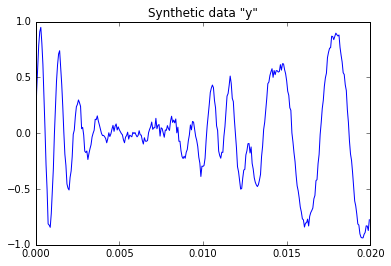

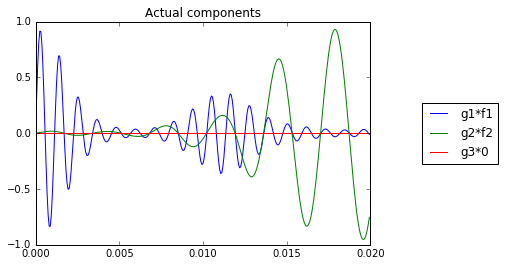

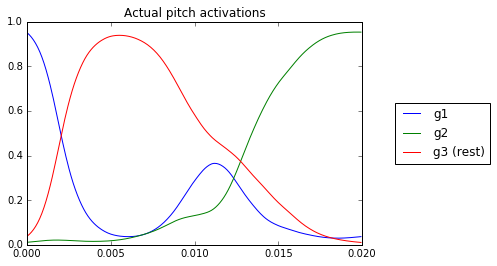

In [12]:
plt.figure()
plt.plot(X,y)
plt.title('Synthetic data "y"')

plt.figure()
plt.plot(X,g1_sig*f_1)
plt.plot(X,g2_sig*f_2)
plt.plot(X,g3_sig*0)
plt.legend(['g1*f1','g2*f2','g3*0'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual components')

plt.figure()
plt.plot(X,g1_sig)
plt.plot(X,g2_sig)
plt.plot(X,g3_sig)
plt.legend(['g1','g2','g3 (rest)'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual pitch activations')

In [5]:
# generate model object
Z = X[::8].copy() # copy inducting points from input vector X
m = modgp.ModGP(X, y, k_f1, k_f2, k_g1, k_g2, k_g3, Z) 

In [6]:
# keep model parameters fixed.
m.kern1.fixed = True
m.kern2.fixed = True
m.kern3.fixed = True
m.kern4.fixed = True
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True

# optimize the approximated distributions over f(t) and g(t).
m.optimize(disp=1,maxiter=2500)

      fun: -547.53476928368639
 hess_inv: <8202x8202 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.32725613,  0.1260228 , -0.13987191, ...,  0.97126321,
        0.070767  , -1.08327782])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 2739
      nit: 2501
   status: 1
  success: False
        x: array([  0.02355504,   0.32934975,  -0.62571678, ...,   0.12431518,
        19.85975516,  -5.3132598 ])

In [7]:
# evaluate predictions over all latent functions
mug1, varg1 = m.predict_g1(X)
mug2, varg2 = m.predict_g2(X)
mug3, varg3 = m.predict_g3(X)

mu_g1_sig, mu_g2_sig, mu_g3_sig = softmax(mug1,mug2,mug3) # pass predicted g processes through softmax function

muf1, varf1 = m.predict_f1(X)
muf2, varf2 = m.predict_f2(X)

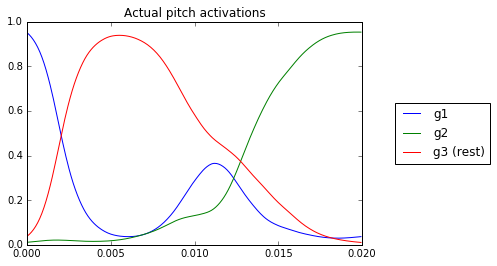

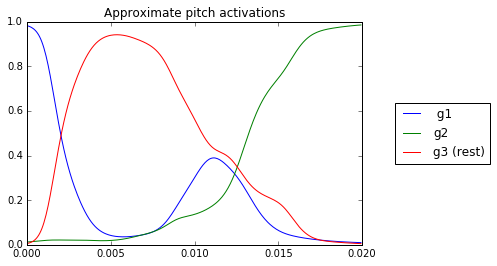

In [8]:
# plot pitch activation functions
plt.figure()
plt.plot(X, g1_sig, lw=1)
plt.plot(X, g2_sig, lw=1)
plt.plot(X, g3_sig, lw=1)
plt.legend(['g1','g2','g3 (rest)'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual pitch activations')

plt.figure()
plt.plot(X, mu_g1_sig,lw=1)
#plt.plot(X, logistic(mu + 2*np.sqrt(var)), 'g--')
#plt.plot(X, logistic(mu - 2*np.sqrt(var)), 'g--')
plt.plot(X, mu_g2_sig,lw=1)
plt.plot(X, mu_g3_sig,lw=1)
#plt.plot(X, mu + 2*np.sqrt(var), 'm--')
#plt.plot(X, mu - 2*np.sqrt(var), 'm--')
plt.title('Approximate pitch activations')
plt.legend([' g1','g2','g3 (rest)'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)



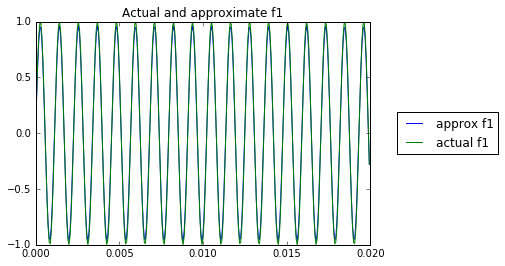

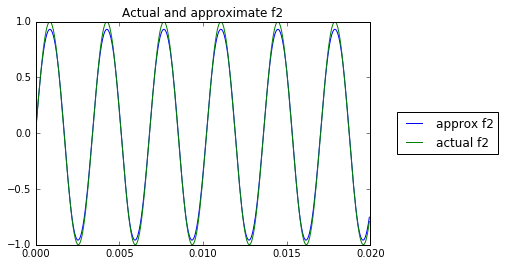

In [9]:
# plot periodic processes
plt.figure()
plt.plot(X,muf1)
plt.plot(X,f_1)
plt.legend(['approx f1','actual f1'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual and approximate f1')

plt.figure()
plt.plot(X,muf2)
plt.plot(X,f_2)
plt.legend(['approx f2','actual f2'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual and approximate f2')

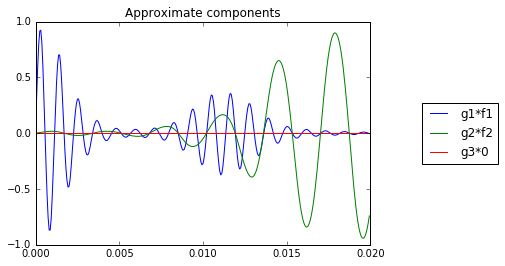

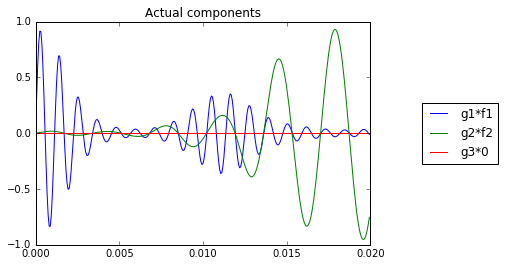

In [10]:
# plot each pitch*envelope component
y_approx =  + mug2*muf2 + mug3*0
plt.plot(X, mu_g1_sig*muf1)
plt.plot(X, mu_g2_sig*muf2)
plt.plot(X, mu_g3_sig*0)
plt.legend(['g1*f1','g2*f2','g3*0'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Approximate components')

plt.figure()
plt.plot(X, g1_sig*f_1)
plt.plot(X, g2_sig*f_2)
plt.plot(X, g3_sig*0)
plt.legend(['g1*f1','g2*f2','g3*0'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual components')

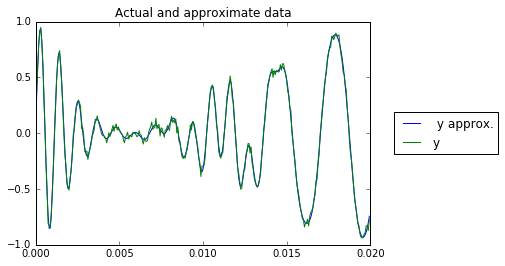

In [11]:
# plot actual data and its approximation
y_approx = mu_g1_sig*muf1 + mu_g2_sig*muf2 + mu_g3_sig*0
plt.plot(X, y_approx)
plt.plot(X, y)
plt.legend([' y approx.','y'],bbox_to_anchor=(1.4, 0.5), loc='center right', ncol=1)
plt.title('Actual and approximate data')